# Practica 1: Analizador de Espectros con BladeRF

In [1]:
%matplotlib inline
import math
from IPython.display import HTML
from matplotlib import animation, pyplot as plt, rc
import numpy as np
from bladerf import _bladerf

## Problema 3.1 Transformada discreta de Fourier (DFT)

In [37]:
def dft(signal):
    """
    Calcular la transforma discreta de fourier de una señal dada.
    Parametros:
    - signal: Señal de entrada en el dominio del tiempo
    - sampling_rate: Tasa de muestreo de la señal en Hz, que determina el ancho de banda 
    Retorna:
    - dft_output: Coeficientes de frecuencia complejos de la DFT
    - freqs: Las frecuencias correspondientes a los coeficientes en Hz
    """
    N = len(signal)
    dft_output = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            dft_output[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
            
    return dft_output

In [38]:
sampling_rate = 1000
t = np.linspace(0, 1, 1000, endpoint=False)
signal = np.sin(2*np.pi * 50 * t) + 0.5 * np.sin(2*np.pi * 120 * t)

In [39]:
dft_result = dft(signal)
np.testing.assert_almost_equal(dft_result, np.fft.fft(signal))
print("Prueba de la DFT correcta")
print("Resultado de la DFT:", dft_result)

Prueba de la DFT correcta
Resultado de la DFT: [-1.55209179e-13+0.00000000e+00j  2.77555756e-15-1.60088956e-14j
 -1.05582210e-13-2.72703735e-13j  2.79332113e-13-8.30186614e-14j
  6.60582700e-14+1.45012474e-13j -2.18158824e-13+9.93337357e-14j
  3.44169138e-14-1.18394877e-13j  1.15907284e-13+5.68364800e-14j
  1.42663659e-13-1.63487279e-13j  4.61852778e-14-1.31047950e-13j
  2.03392858e-13-2.08548456e-13j  2.25486296e-13+2.54005150e-13j
 -2.37143638e-13-1.14290521e-13j  4.72955008e-14-3.20438120e-14j
  1.42219569e-13+3.77128884e-14j  1.86739513e-13+1.76747506e-13j
  6.30606678e-14-6.00214323e-14j -1.99840144e-15+2.32189268e-13j
  4.20774526e-14+2.74696932e-13j -3.65485420e-13-5.49282841e-14j
  4.08784118e-13-1.22235555e-13j  1.76858528e-13+1.56250013e-13j
 -1.38444811e-13+2.70061751e-14j -1.48658863e-13-5.64687186e-14j
 -6.31716901e-14-7.23032745e-14j -1.29896094e-14+3.93990396e-14j
  2.33146835e-14-3.61169428e-13j  6.95221658e-13+2.31009656e-13j
 -2.06279438e-13+5.59788327e-13j -2.9420910

## Problema 3.2: Entendiendo la frecuencia

In [40]:
# Definimos la señal
signal = np.exp(1j * 2 * np.pi * (2.5 / 128) * np.arange(128))

In [41]:
# Calculamos la DFT usando la funcion dft que definimos anteriormente
dft_signal = dft(signal)

### a. Grafique la DFT de esta señal (La DFT es compleja, solo grafique la magnitud de esta señal).

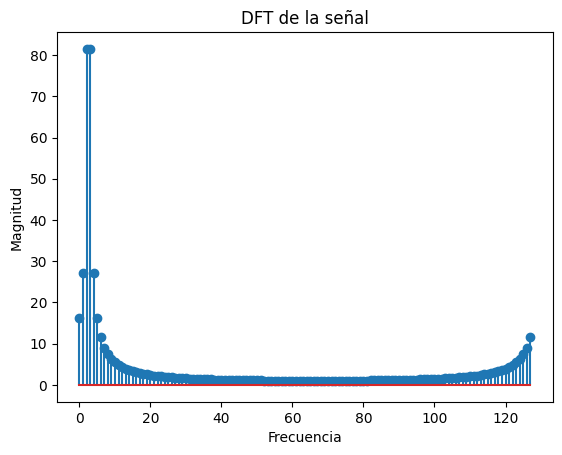

In [42]:
plt.figure()
plt.stem(np.abs(dft_signal))
plt.title("DFT de la señal")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

### b. Doble el tamaño de la señal colocando zeros al final y grafique su DFT. Comente los resultados.

In [43]:
zero_padded_signal = np.concatenate((signal, np.zeros(128)))

In [44]:
dft_zero_padded_signal = dft(zero_padded_signal)

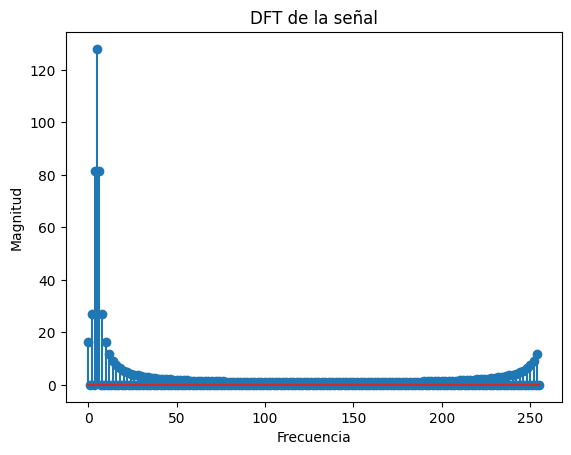

In [45]:
plt.figure()
plt.stem(np.abs(dft_zero_padded_signal))
plt.title("DFT de la señal")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

### c. La DFT de la señal con zeros tiene el doble de puntos que la original. ¿Qué frecuencias k de la DFT de la señal con ceros son las mismas que las de la DFT de la señal original?

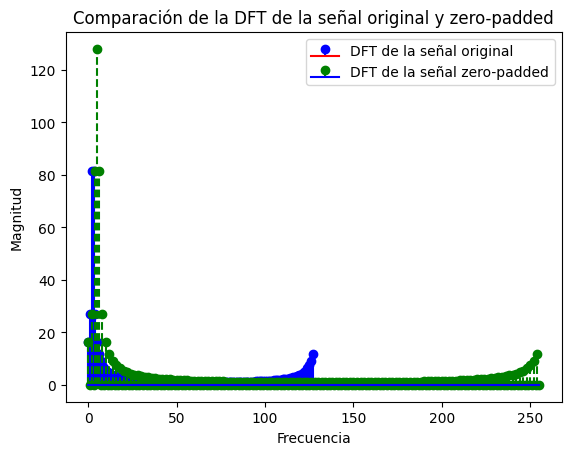

In [46]:
plt.figure()
plt.stem(np.abs(dft_signal), linefmt='b-', markerfmt='bo', basefmt='r-', label='DFT de la señal original')
plt.stem(np.abs(dft_zero_padded_signal), linefmt='g--', markerfmt='go', basefmt='b-', label='DFT de la señal zero-padded')
plt.title("Comparación de la DFT de la señal original y zero-padded")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.legend()
plt.show()

## 3.3. Ajustes finos de frecuencia

In [47]:
def get_freq_component(signal, k):
    N = len(signal)
    result = 0
    for n in range(N):
        result += signal[n] * np.exp(-2j * np.pi * k * n / N)
    return result

signal = np.exp(1j * 2 * np.pi * (2.5 / 128) * np.arange(128))
print(get_freq_component(signal, 0.123))
print(get_freq_component(signal, 0.555))
print(get_freq_component(signal, 0.999))

(6.834732696442442+14.340484976955768j)
(-3.515668926161199+0.788110390412262j)
(0.9147527912601011+27.134940040759457j)


## 3.4. Filtrado paso bajo con la DFT

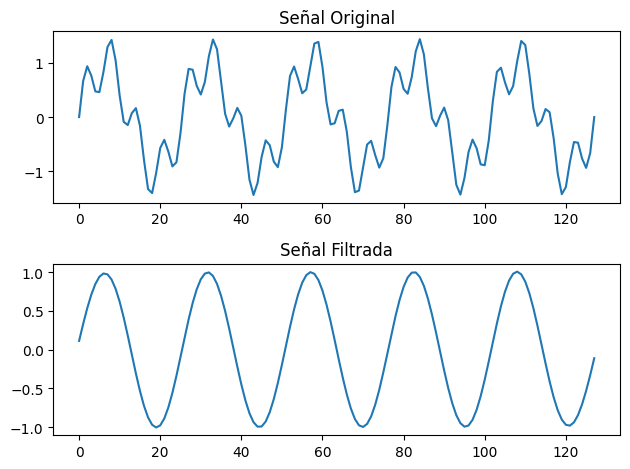

In [48]:
def low_pass_filter(signal, cutoff):
    signal_dft = np.fft.fft(signal)
    N = len(signal_dft)
    # Aplicar el filtro low-pass: frecuencias menores al cutoff se reemplazan por cero
    for k in range(cutoff, N - cutoff):
        signal_dft[k] = 0
    # Reconstruir la señal filtrada
    filtered_signal = np.fft.ifft(signal_dft)
    return filtered_signal

test_signal = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 128)) + 0.5 * np.sin(2 * np.pi * 20 * np.linspace(0, 1, 128))
cutoff = 10  
filtered_signal = low_pass_filter(test_signal, cutoff)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(test_signal)
plt.title("Señal Original")

plt.subplot(2, 1, 2)
plt.plot(filtered_signal.real)
plt.title("Señal Filtrada")
plt.tight_layout()
plt.show()

## Interfaz con un SDR (bladeRF)

### a. Luego de revisar el manual de uso del bladeRF, sintoniza tu BladeRF a una frecuencia central de 1250MHz con un ancho de banda de 5MHz y captura 1M de muestras. Traza las muestras en el dominio del tiempo y en el dominio de la frecuencia (es decir, después de aplicar la DFT).

In [5]:
# Define parameters
sample_rate = 10e6    # 10 kHz sample rate
center_freq = 100e6  # 100 MHz center frequency
bandwidth = 5e6       # 5 MHz bandwidth
gain = 50             # Gain in dB
num_samples = int(1e6)  # 1 million samples

[INFO @ /privatehost/libraries/libbladeRF/src/helpers/version.c:106] FPGA version (v0.15.3) is newer than entries in libbladeRF's compatibility table. Please update libbladeRF if problems arise.


Device info: Device Information
    backend  libusb
    serial   ddbfc62f459b43e185256d1daa7c9073
    usb_bus  1
    usb_addr 1
    instance 0
libbladeRF version: v2.5.0 ("2.5.0-git-41ef6346-dirty")
Firmware version: v2.4.0 ("2.4.0-git-a3d5c55f")
FPGA version: v0.15.3 ("0.15.3")
Starting receive
Stopping


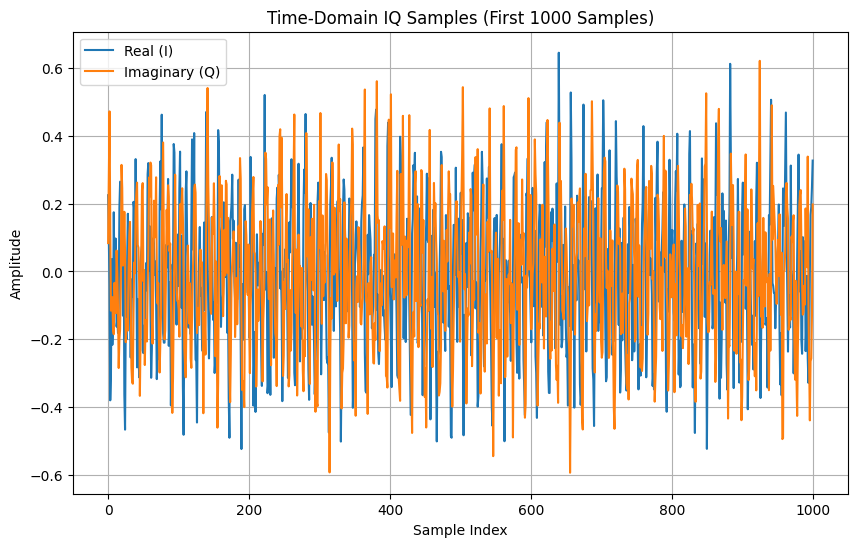

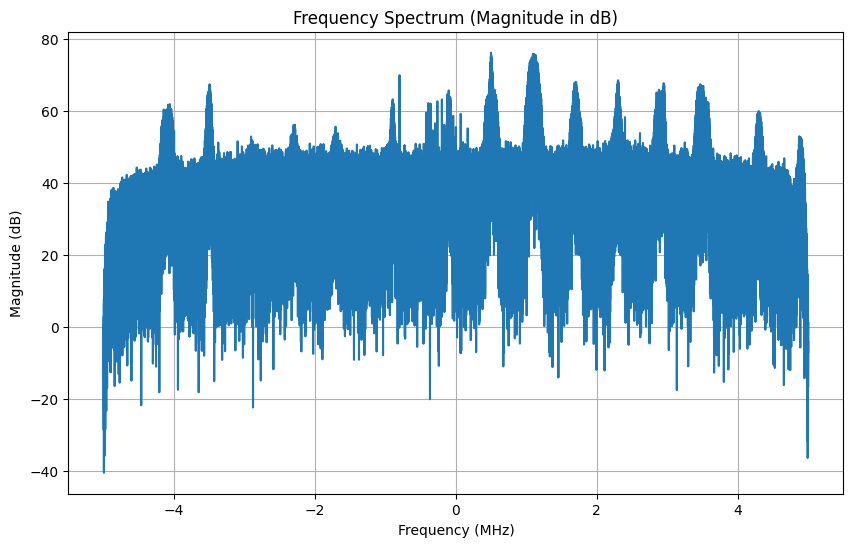

In [6]:
# Initialize BladeRF device
sdr = _bladerf.BladeRF()

# Print device and version info
print("Device info:", _bladerf.get_device_list()[0])
print("libbladeRF version:", _bladerf.version())
print("Firmware version:", sdr.get_fw_version())
print("FPGA version:", sdr.get_fpga_version())

# Set up the RX channel (0 for RX)
rx_ch = sdr.Channel(_bladerf.CHANNEL_RX(0))

# Configure RX channel
rx_ch.frequency = center_freq
rx_ch.sample_rate = sample_rate
rx_ch.bandwidth = bandwidth
rx_ch.gain_mode = _bladerf.GainMode.Manual
rx_ch.gain = gain

# Setup synchronous stream
sdr.sync_config(layout = _bladerf.ChannelLayout.RX_X1,  # Single channel RX
                fmt = _bladerf.Format.SC16_Q11,         # 16-bit signed integer
                num_buffers = 16,
                buffer_size = 8192,
                num_transfers = 8,
                stream_timeout = 3500)

# Create receive buffer
bytes_per_sample = 4  # 2 bytes each for I and Q
buf = bytearray(1024 * bytes_per_sample)

# Enable the RX module
print("Starting receive")
rx_ch.enable = True

# Create an array for storing complex samples
x = np.zeros(num_samples, dtype=np.complex64)
num_samples_read = 0

# Receive loop to capture 1M samples
while num_samples_read < num_samples:
    num = min(len(buf) // bytes_per_sample, num_samples - num_samples_read)
    sdr.sync_rx(buf, num)  # Read into buffer
    samples = np.frombuffer(buf, dtype=np.int16)
    # Convert to complex IQ (I + jQ)
    iq_samples = samples[0::2] + 1j * samples[1::2]
    iq_samples /= 2048.0  # Scale to -1 to 1 (12-bit ADC)
    x[num_samples_read:num_samples_read+num] = iq_samples[:num]
    num_samples_read += num

# Disable RX
print("Stopping")
rx_ch.enable = False

# Plot the results

# a) Plot time-domain IQ samples (real and imaginary parts)
plt.figure(figsize=(10, 6))
plt.plot(np.real(x[:1000]), label="Real (I)")
plt.plot(np.imag(x[:1000]), label="Imaginary (Q)")
plt.title("Time-Domain IQ Samples (First 1000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# b) Compute and plot the DFT (spectrum in frequency domain)
spectrum = np.fft.fftshift(np.fft.fft(x))
freqs = np.fft.fftshift(np.fft.fftfreq(num_samples, 1 / sample_rate))

plt.figure(figsize=(10, 6))
plt.plot(freqs / 1e3, 20 * np.log10(np.abs(spectrum)))
plt.title("Frequency Spectrum (Magnitude in dB)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.show()


## 3.6. Afinando la recepción

[INFO @ /privatehost/libraries/libbladeRF/src/helpers/version.c:106] FPGA version (v0.15.3) is newer than entries in libbladeRF's compatibility table. Please update libbladeRF if problems arise.


Información del dispositivo: Device Information
    backend  libusb
    serial   ddbfc62f459b43e185256d1daa7c9073
    usb_bus  1
    usb_addr 1
    instance 0
Versión de libbladeRF: v2.5.0 ("2.5.0-git-41ef6346-dirty")
Versión del firmware: v2.4.0 ("2.4.0-git-a3d5c55f")
Versión del FPGA: v0.15.3 ("0.15.3")
Iniciando recepción
Deteniendo recepción


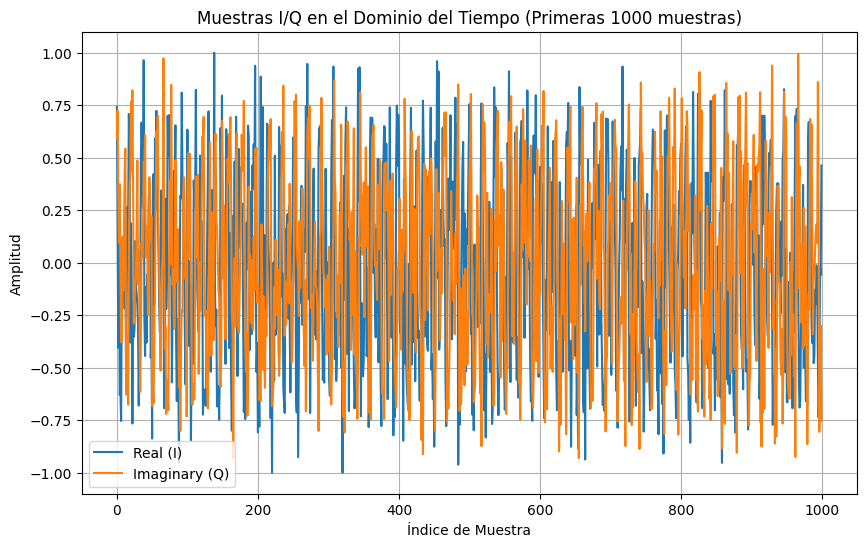

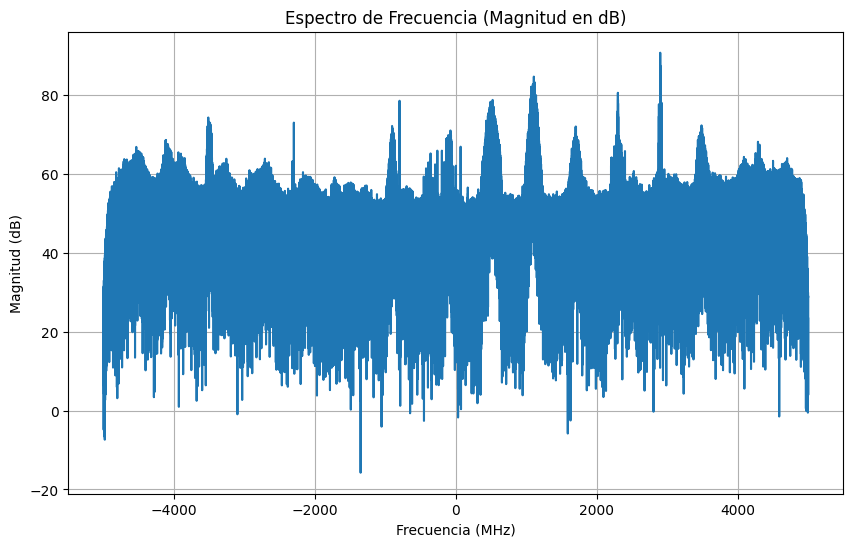

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from bladerf import _bladerf

# Parámetros de configuración
center_freq = 100e6     # Frecuencia central: 100 MHz
sample_rate = 10e6      # Tasa de muestreo: 10 MHz
bandwidth = 5e6         # Ancho de banda: 5 MHz
gain = 60               # Ganancia máxima del BladeRF (60 dB)
num_samples = int(1e6)  # Número de muestras a capturar: 1M

# Inicializar dispositivo BladeRF
sdr = _bladerf.BladeRF()

# Imprimir información del dispositivo y versiones
print("Información del dispositivo:", _bladerf.get_device_list()[0])
print("Versión de libbladeRF:", _bladerf.version())
print("Versión del firmware:", sdr.get_fw_version())
print("Versión del FPGA:", sdr.get_fpga_version())

# Configurar el canal RX (canal 0)
rx_ch = sdr.Channel(_bladerf.CHANNEL_RX(0))

# Configurar el canal de recepción RX
rx_ch.frequency = center_freq     # Frecuencia central
rx_ch.sample_rate = sample_rate   # Tasa de muestreo
rx_ch.bandwidth = bandwidth       # Ancho de banda
rx_ch.gain_mode = _bladerf.GainMode.Manual  # Modo de ganancia manual
rx_ch.gain = gain                 # Máxima ganancia (60 dB)

# Configurar stream síncrono
sdr.sync_config(layout=_bladerf.ChannelLayout.RX_X1,  # Canal RX único
                fmt=_bladerf.Format.SC16_Q11,         # 16-bit signed integer
                num_buffers=16,
                buffer_size=8192,
                num_transfers=8,
                stream_timeout=3500)

# Crear buffer para recibir muestras
bytes_per_sample = 4  # 2 bytes para I y 2 bytes para Q
buf = bytearray(1024 * bytes_per_sample)

# Habilitar el canal RX
print("Iniciando recepción")
rx_ch.enable = True

# Crear un array para almacenar muestras complejas
x = np.zeros(num_samples, dtype=np.complex64)
num_samples_read = 0

# Bucle para capturar las muestras
while num_samples_read < num_samples:
    num = min(len(buf) // bytes_per_sample, num_samples - num_samples_read)
    sdr.sync_rx(buf, num)  # Leer datos al buffer
    samples = np.frombuffer(buf, dtype=np.int16)  # Convertir buffer a enteros de 16 bits
    iq_samples = samples[0::2] + 1j * samples[1::2]  # Convertir a I/Q complejos
    iq_samples /= 2048.0  # Escalar para normalizar (-1 a 1, debido al ADC de 12 bits)
    x[num_samples_read:num_samples_read + num] = iq_samples[:num]  # Guardar muestras
    num_samples_read += num  # Actualizar el contador

# Deshabilitar el canal RX
print("Deteniendo recepción")
rx_ch.enable = False

# a) Graficar las muestras I/Q en el dominio del tiempo
plt.figure(figsize=(10, 6))
plt.plot(np.real(x[:1000]), label="Real (I)")  # Parte real (I)
plt.plot(np.imag(x[:1000]), label="Imaginary (Q)")  # Parte imaginaria (Q)
plt.title("Muestras I/Q en el Dominio del Tiempo (Primeras 1000 muestras)")
plt.xlabel("Índice de Muestra")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()

# b) Calcular y graficar el espectro (DFT) en el dominio de la frecuencia
spectrum = np.fft.fftshift(np.fft.fft(x))  # FFT y centrado
freqs = np.fft.fftshift(np.fft.fftfreq(num_samples, 1 / sample_rate))  # Frecuencias

# Graficar el espectro en el dominio de la frecuencia
plt.figure(figsize=(10, 6))
plt.plot(freqs / 1e3, 20 * np.log10(np.abs(spectrum)))  # Magnitud en dB
plt.title("Espectro de Frecuencia (Magnitud en dB)")
plt.xlabel("Frecuencia (MHz)")
plt.ylabel("Magnitud (dB)")
plt.grid()
plt.show()
